In [1]:
%load_ext autoreload
%autoreload 2
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch
from causal_analysis.helpers import get_df_from_logdir, CPU_Unpickler
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.dots_learner import DotsLearner
from sparse_causal_model_learner_rl.config import Config
import pickle
from tqdm.auto import tqdm
from torch import nn

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/dots.gin'])

['dots']

In [3]:
#learner = pickle.load(open(os.path.join(ckpt_dir, 'checkpoint_0', 'checkpoint'), 'rb'))
learner = DotsLearner(Config())

In [4]:
learner.collect_steps()

COLLECTING DATA!!!


In [5]:
data = learner._context['X_chw']

In [6]:
learner.collect_steps()

COLLECTING DATA!!!


In [7]:
data_test = learner._context['X_chw']

In [8]:
assert torch.norm(data - data_test).item() > 0

In [9]:
data_test.shape

torch.Size([10000, 3, 5, 5])

In [29]:
RGB = 3
N_OBJ = 6
CONV_FACTOR = 2
COORD_FACTOR = 5
H, W = 5, 5

In [31]:
class CustomEncoder(nn.Module):
    def __init__(self):
        super(CustomEncoder, self).__init__()
        self.conv_obj = nn.Conv2d(in_channels=RGB, out_channels=N_OBJ * CONV_FACTOR, kernel_size=(1, 1))
        # N_OBJ * CONV_FACTOR
        self.conv_x  = nn.Conv2d(in_channels=N_OBJ * CONV_FACTOR, out_channels=N_OBJ * CONV_FACTOR, kernel_size=(H, 1),
                                 groups=N_OBJ * CONV_FACTOR)
        self.conv_x1 = nn.Conv2d(in_channels=N_OBJ * CONV_FACTOR, out_channels=N_OBJ * CONV_FACTOR, kernel_size=(1, W),
                                 groups=N_OBJ * CONV_FACTOR)

        
        self.conv_y  = nn.Conv2d(in_channels=N_OBJ * CONV_FACTOR, out_channels=N_OBJ * CONV_FACTOR, kernel_size=(1, W),
                                 groups=N_OBJ * CONV_FACTOR)
        self.conv_y1 = nn.Conv2d(in_channels=N_OBJ * CONV_FACTOR, out_channels=N_OBJ * CONV_FACTOR, kernel_size=(H, 1),
                                 groups=N_OBJ * CONV_FACTOR)
#         + softmax over all positions

        
    def forward(self, x):
        x = self.conv_obj(x) # shape n_obj, h, w
#         x = nn.Sigmoid(x) # objects space

        x_flat = x.view(-1, N_OBJ * CONV_FACTOR, H * W)
        x = nn.Softmax(2)(x_flat * 10).view_as(x)

        x_x = self.conv_x(x) # shape 1, w
        x_x = self.conv_x1(x_x) # shape 1, 1
        x_x = torch.flatten(x_x, start_dim=1) # shape n_obj * factor, x-coordinate
        
        x_y = self.conv_y(x) # shape h, 1
        x_y = self.conv_y1(x_y) # shape 1, 1
        x_y = torch.flatten(x_y, start_dim=1) # shape batch, n_obj * factor
        
        out = torch.cat([x_x, x_y], dim=1)
        return out
    
class BiasAdder(nn.Module):
    def __init__(self, n_items, n_expand=1):
        """Add bias and broadcast.
        
        in_shape: [batch (silent), n_items]
        out_shape: [batch, n_items, n_expand]
        
        weight shape: [expand] (same for every item)
        """
        super(BiasAdder, self).__init__()
        self.n_items = n_items
        self.n_expand = n_expand
        
        self.bias = nn.Parameter(torch.Tensor(n_expand,))
        self.weight = nn.Parameter(torch.Tensor(1,))
        torch.nn.init.zeros_(self.bias)
        torch.nn.init.ones_(self.weight)
        
    def forward(self, x):
        assert len(x.shape) == 2
#         torch.einsum('bn,z->bnz')
        x = x.view(*x.shape, 1)
        return (x + self.bias) * self.weight

    
class CustomDecoder(nn.Module):
    def __init__(self):
        super(CustomDecoder, self).__init__()
        
        self.pb_x = BiasAdder(n_items=N_OBJ * CONV_FACTOR, n_expand=H * COORD_FACTOR)
        self.pb_y = BiasAdder(n_items=N_OBJ * CONV_FACTOR, n_expand=W * COORD_FACTOR)
        
#         self.one_hot_x = nn.ConvTranspose2d(in_channels=N_OBJ * CONV_FACTOR, out_channels=N_OBJ * CONV_FACTOR, kernel_size=(H * COORD_FACTOR, 1))
#         self.one_hot_y = nn.ConvTranspose2d(in_channels=N_OBJ * CONV_FACTOR, out_channels=N_OBJ * CONV_FACTOR, kernel_size=(1, W * COORD_FACTOR))
        
        self.one_hot_x = nn.Conv2d(in_channels=N_OBJ * CONV_FACTOR, out_channels=N_OBJ * CONV_FACTOR, kernel_size=(COORD_FACTOR, 1),
                                   stride=(COORD_FACTOR, 1), groups=N_OBJ * CONV_FACTOR)
        
        self.one_hot_y = nn.Conv2d(in_channels=N_OBJ * CONV_FACTOR, out_channels=N_OBJ * CONV_FACTOR, kernel_size=(COORD_FACTOR, 1),
                                   stride=(COORD_FACTOR, 1), groups=N_OBJ * CONV_FACTOR)
    
        self.to_rgb = nn.Conv2d(in_channels=N_OBJ * CONV_FACTOR, out_channels=RGB, kernel_size=(1, 1))
        
    def forward(self, x):
        xdim = x.shape[1] // 2
        x_x = x[:, :xdim]
        x_y = x[:, xdim:]
        
#         x_x = x_x.view(-1, xdim, 1, 1) # 1x1 image
#         x_y = x_y.view(-1, xdim, 1, 1)
        
        pb_x = self.pb_x(x_x) # shape batch, obj*conv_factor, H * coord
        pb_y = self.pb_y(x_y) # shape batch, obj*conv_factor, W * coord
        
        pb_x = nn.Sigmoid()(pb_x) # progressbar encoding
        pb_y = nn.Sigmoid()(pb_y)
        
        pb_x = pb_x.view(*pb_x.shape, 1) # size x 1
        pb_y = pb_y.view(*pb_y.shape, 1)
        
        oh_x = self.one_hot_x(pb_x)
        oh_x = oh_x.view(oh_x.shape[0], N_OBJ * CONV_FACTOR, H) # size batch, obj*conv, H
        oh_y = self.one_hot_y(pb_y)
        oh_y = oh_y.view(oh_y.shape[0], N_OBJ * CONV_FACTOR, W) # size batch, obj*conv, W
        
        oh_x = nn.Softmax(2)(oh_x * 10)
        oh_y = nn.Softmax(2)(oh_y * 10)
        
        oh_xy = torch.einsum('bcn,bcm->bcnm', oh_x, oh_y)
        
        oh_rgb = self.to_rgb(oh_xy)
        
        return oh_rgb
        

class CustomAutoEncoder(nn.Module):
    def __init__(self):
        super(CustomAutoEncoder, self).__init__()
        self.encoder = CustomEncoder()
        self.decoder = CustomDecoder()
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

ae = CustomAutoEncoder()

In [32]:
x = torch.from_numpy(np.random.randn(10, 24))
b = torch.from_numpy(np.ones(91,))

In [14]:
(x.view(10, 24, 1) + b).shape

torch.Size([10, 24, 91])

In [15]:
torch.einsum('bn,z->bnz', x, b)[3, 4, :]

tensor([0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841,
        0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841,
        0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841,
        0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841,
        0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841,
        0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841,
        0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841,
        0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841,
        0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841,
        0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841, 0.9841,
        0.9841], dtype=torch.float64)

In [16]:
obss = torch.from_numpy(np.array(np.random.randn(10, 3, 5, 5), dtype=np.float32))

In [17]:
enc = CustomEncoder()

In [18]:
2 * N_OBJ * CONV_FACTOR

24

In [19]:
enc(obss).shape

torch.Size([10, 24])

In [20]:
# no, it multiplies by a value
# in_ch=fixed, out_ch=fixed, tensor_shape=[1,5] -- will be multiplied
# say, x=1 -> 1 2 3 4 but need sigmoid(x-x0) -> conv size 2
l = nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=(1, 5))

In [21]:
[(x[0], x[1].shape) for x in l.named_parameters()]

[('weight', torch.Size([6, 6, 1, 5])), ('bias', torch.Size([6]))]

In [65]:
ae = CustomAutoEncoder().cuda()

In [66]:
opt = torch.optim.Adam(ae.parameters(), lr=1e-2)

In [67]:
def loss_fcn(y_true, y_pred):
    delta = y_true - y_pred
    delta = torch.abs(delta)
    delta = delta ** 2
    delta = torch.mean(delta, dim=0)
    delta = torch.sum(delta)
    return delta

In [68]:
losses = []
losses_test = []
grads = []

test_every = 100

In [69]:
[(x[0], x[1].shape) for x in ae.named_parameters()]

[('encoder.conv_obj.weight', torch.Size([12, 3, 1, 1])),
 ('encoder.conv_obj.bias', torch.Size([12])),
 ('encoder.conv_x.weight', torch.Size([12, 1, 5, 1])),
 ('encoder.conv_x.bias', torch.Size([12])),
 ('encoder.conv_x1.weight', torch.Size([12, 1, 1, 5])),
 ('encoder.conv_x1.bias', torch.Size([12])),
 ('encoder.conv_y.weight', torch.Size([12, 1, 1, 5])),
 ('encoder.conv_y.bias', torch.Size([12])),
 ('encoder.conv_y1.weight', torch.Size([12, 1, 5, 1])),
 ('encoder.conv_y1.bias', torch.Size([12])),
 ('decoder.pb_x.bias', torch.Size([25])),
 ('decoder.pb_x.weight', torch.Size([1])),
 ('decoder.pb_y.bias', torch.Size([25])),
 ('decoder.pb_y.weight', torch.Size([1])),
 ('decoder.one_hot_x.weight', torch.Size([12, 1, 5, 1])),
 ('decoder.one_hot_x.bias', torch.Size([12])),
 ('decoder.one_hot_y.weight', torch.Size([12, 1, 5, 1])),
 ('decoder.one_hot_y.bias', torch.Size([12])),
 ('decoder.to_rgb.weight', torch.Size([3, 12, 1, 1])),
 ('decoder.to_rgb.bias', torch.Size([3]))]

In [70]:
for i in tqdm(range(5000)):
    opt.zero_grad()
    loss = loss_fcn(data, ae(data))
    loss.backward()
    
    grad = [x.grad for x in ae.parameters()]
    grad = np.max([torch.max(torch.abs(x)).item() for x in grad])
    grads.append(grad)
    
    opt.step()
    losses.append(loss.item())
    
    losses_test.append(loss_fcn(data_test, ae(data_test)).item())

In [71]:
grad = [x.grad for x in ae.parameters()]
grad = np.max([torch.max(torch.abs(x)).item() for x in grad])

In [72]:
grad

1.980034351348877

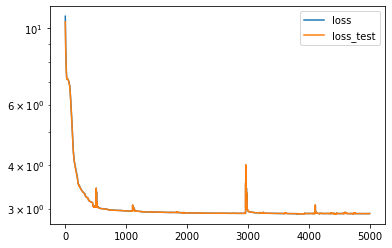

In [74]:
plt.plot(losses, label='loss')
plt.plot(losses_test, label='loss_test')

# plt.plot(grads, label='grad')
plt.legend()
plt.yscale('log')